# Predicting Meteoroid Conditions

## Preliminar

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize,bisect
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid
from tqdm import tqdm
from scipy.stats import linregress
from glob import glob
from datetime import datetime
%matplotlib nbagg

#Routines
def ipercs(xs,ps,qpercs):
    """
    Compute percentiles from a numerical normalized distribution ps
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

#Routines to convert from local to body systems and viceversa
def loc2rec(vp,distance,Az,h):
    """
    Convert distance, azimuth and elevation to position w.r.t. Earth
    vp (dictionary): Vantage point.  It should have: lon, lat, alt
    distance: km
    Az: deg
    h: deg
    """
    rlocal=spy.latrec(distance,Az*DEG,h*DEG)
    rpos=spy.mxv(vp["l2b"],rlocal)+vp["geopos"]
    return rpos


def rec2loc(vp,rpos):
    """
    Convert position w.r.t. Earth to distance, Azimuth and elevation
    distance: km
    Az: deg
    h: deg
    """
    rrel=rpos-vp["geopos"]
    rlocal=spy.mxv(vp["b2l"],rrel)
    distance,Az,h=spy.reclat(rlocal)
    Az=2*np.pi+Az if Az<0 else Az
    return distance,Az*RAD,h*RAD

def recv2loc(vp,rpos):
    """
    Convert position w.r.t. Earth to distance, Azimuth and elevation
    distance: km
    Az: deg
    h: deg
    """
    rrel=rpos
    rlocal=spy.mxv(vp["b2l"],rrel)
    distance,Az,h=spy.reclat(rlocal)
    Az=2*np.pi+Az if Az<0 else Az
    return distance,Az*RAD,h*RAD

def updateVantagePoint(vp):
    """
    Compute related geometrical properties of a vantage point
    """
    vp["geopos"]=spy.georec(vp["lon"]*DEG,vp["lat"]*DEG,vp["alt"],RE,F)
    normal=spy.surfnm(RE,RE,RP,vp["geopos"])
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    vp["l2b"]=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    vp["b2l"]=np.linalg.inv(vp["l2b"])
    
def greatCircle(lon1,lat1,lon2,lat2):
    a=np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2
    gd=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return gd

### SPICE specifics

In [2]:
BDIR="./"
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/earth_070425_370426_predict.bpc")
spy.furnsh(BDIR+"kernels/earth_assoc_itrf93.tf")
#Astronomical constants
n,rs=spy.bodvrd("EARTH","RADII",3)
RE=rs[0];RP=rs[2]
F=(RE-RP)/RE

### Macro and Constants

In [3]:
#Directories
FIGDIR=BDIR+"figures/"

#Macros
norm=np.linalg.norm
DEG=np.pi/180
RAD=1/DEG

#Fitting procedure
lengthTestTrajectory=300 #km
npointsTestTrajectory=50

## Impact data

In [4]:
#Read vantage positions position
havana=pd.read_csv("data/havana-observations-final.csv",decimal=",")
florida=pd.read_csv("data/florida-observations-final.csv",decimal=",")
pinar=pd.read_csv("data/pinardelrio-observations-final.csv",decimal=",")

#Build vantage points dictionary
#T in C, P in kPa.  Weather data taken from historical data in : https://www.wunderground.com
vantagePoints=dict(
    impact=dict(
        location="Impact",
        obstraj_nocorr=None,
        lon=0,lat=0,alt=0,
        Azref=0.0,
        T=0,P=0,
    ),
    havana=dict(
        location="Havana harbor",
        obstraj_nocorr=havana,
        #lon=-82.344343,lat=23.13799,alt=0/1000.,
        lon=-82.344328,lat=23.137768,alt=0/1000., #Improved 
        Azref=0.0,
        T=30.0,P=101.0,
    ),
    florida=dict(
        location="GullWing Beach Resort (Florida)",
        obstraj_nocorr=florida,
        lon=-81.903596,lat=26.418871,alt=1/1000.,
        Azref=201.6,
        T=25.0,P=102.3,
    ),
    pinar=dict(
        location="Pinar del Rio (Cuba)",
        obstraj_nocorr=pinar,
        #lon=-83.692091,lat=22.414536,alt=48/1000.,
        lon=-83.692107,lat=22.414545,alt=48/1000., #Improved
        Azref=0.0,
        T=30.0,P=101.0,
    ),
)

#Geometrical properties of the vantage point
for key,vp in vantagePoints.items():updateVantagePoint(vp)
nvp=len(vantagePoints.keys())-1

In [5]:
vantagePoints["florida"]["obstraj_nocorr"]

,h,herr,Az,Azerr,t
0,2.507044,0.253077,10.147311,0.110721,0.4375
1,2.348871,0.253077,10.202645,0.110721,0.5000
2,2.000890,0.253077,10.526421,0.110721,0.8125
3,1.621274,0.253077,10.811132,0.110721,0.9375
4,1.099303,0.253077,11.199208,0.110721,1.9375
5,0.838317,0.253077,11.452074,0.110721,2.3125


### Correct observations using atmospheric refraction

In [6]:
def Ratm(ha,epsilon):
    """
    Benett formula
    See: https://en.wikipedia.org/wiki/Atmospheric_refraction
    """
    R=1/np.tan((ha+7.31/(ha+4.4))*DEG)
    return R/60.0

In [7]:
for key,vp in vantagePoints.items():
    if key=="impact":continue
    
    print(f"Correcting {key}")
    #Observed trajectory
    obstraj=vp["obstraj_nocorr"]
    vp["obstraj"]=deepcopy(obstraj)
    
    #Correction factor for atmospheric refraction
    #See: https://en.wikipedia.org/wiki/Atmospheric_refraction, Seamundsson formula
    epsilon=vp["P"]/101.0*283./(273+vp["T"])
    #print(f"Weather correction:{epsilon}")
    
    #Atmospheric refraction
    for ind in vp["obstraj_nocorr"].index:
        ha=vp["obstraj_nocorr"].loc[ind,"h"]
        #print(f"Apparent: {ha} deg")
        R=Ratm(ha,epsilon)
        h=ha-R
        vp["obstraj"].loc[ind,"h"]=h
        #print(f"True: {h}")    

Correcting havana
Correcting florida
Correcting pinar


In [8]:
key="florida"
#key="pinar"
#key="havana"
vantagePoints[key]["obstraj_nocorr"],vantagePoints[key]["obstraj"]

(          h      herr         Az     Azerr       t
 0  2.507044  0.253077  10.147311  0.110721  0.4375
 1  2.348871  0.253077  10.202645  0.110721  0.5000
 2  2.000890  0.253077  10.526421  0.110721  0.8125
 3  1.621274  0.253077  10.811132  0.110721  0.9375
 4  1.099303  0.253077  11.199208  0.110721  1.9375
 5  0.838317  0.253077  11.452074  0.110721  2.3125,
           h      herr         Az     Azerr       t
 0  2.239556  0.253077  10.147311  0.110721  0.4375
 1  2.070962  0.253077  10.202645  0.110721  0.5000
 2  1.697359  0.253077  10.526421  0.110721  0.8125
 3  1.284750  0.253077  10.811132  0.110721  0.9375
 4  0.706331  0.253077  11.199208  0.110721  1.9375
 5  0.411044  0.253077  11.452074  0.110721  2.3125)

## Chi-square computation

In [9]:
def chiSquare(param,vps,avoid=[],verbose=False,npoints=npointsTestTrajectory):
    
    #Input parameters
    lonProj=param[0] # deg
    latProj=param[1] # deg
    hrad=param[2] #deg 
    Azrad=param[3] #deg
    
    #Impact position
    vantagePoints["impact"]["lon"]=lonProj
    vantagePoints["impact"]["lat"]=latProj
    vantagePoints["impact"]["alt"]=0.0
    updateVantagePoint(vantagePoints["impact"])
    
    #Reference Azimuth in Florida
    vantagePoints["florida"]["Azref"]=param[4]
    
    #Direction of radiant
    r=loc2rec(vps["impact"],1,Azrad,hrad)-vps["impact"]["geopos"]
    uimp,magn=spy.unorm(r)
    
    #Trajectory with this conditions
    trajectory=np.zeros((npoints,3))
    for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
        trajectory[i]=uimp*t+vps["impact"]["geopos"]
        
    #Az,h points of trayectory in vantage point vp
    chi2=0
    for key,vp in vps.items():
        if key=="impact" or key in avoid:continue

        #Compute theoretical trajectory
        vp["theotraj"]=np.zeros((npoints,2))
        for i in range(len(trajectory)):
            rpos=trajectory[i]
            d,Az,h=rec2loc(vp,rpos)
            vp["theotraj"][i]=np.array([Az,h])
        
        #Compute chisquare for this vantage point
        otraj=vp["obstraj"].values
        dAzmat=np.array([((otraj[i,2]+vp["Azref"])-vp["theotraj"][:,0])**2/otraj[i,3]**2 for i in range(len(otraj))])
        dhmat=np.array([(otraj[i,0]-vp["theotraj"][:,1])**2/otraj[i,1]**2 for i in range(len(otraj))])
        dposmat=np.sqrt(dAzmat+dhmat)
        chi=dposmat.min(axis=1).sum()
        chi2+=(dposmat.min(axis=1).sum()) #/len(otraj)
            
    return chi2

### Minimization

      fun: 25.950881859088085
 hess_inv: array([[ 1.15244700e-04, -2.53723646e-05, -1.19685070e-03,
         7.72570653e-04, -1.38490378e-03],
       [-2.53723646e-05,  7.45743065e-06,  3.06888446e-04,
         4.52452172e-04,  3.69320574e-04],
       [-1.19685070e-03,  3.06888446e-04,  2.45125725e-02,
         2.31407406e-02,  1.72299807e-02],
       [ 7.72570653e-04,  4.52452172e-04,  2.31407406e-02,
         2.38534656e-01,  1.42814406e-02],
       [-1.38490378e-03,  3.69320574e-04,  1.72299807e-02,
         1.42814406e-02,  1.96110788e-02]])
      jac: array([-1.14244556e+00, -3.52535510e+00, -1.79355145e-02,  1.38280392e-02,
       -3.29208374e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 801
      nit: 23
     njev: 113
   status: 2
  success: False
        x: array([-83.82644838,  22.90718073,  31.13384843, 174.09842479,
       193.1647218 ])

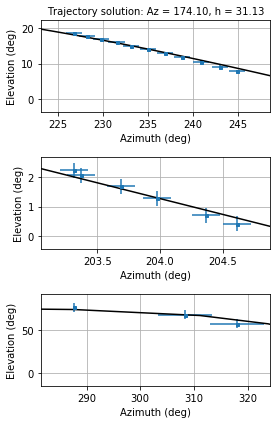

In [10]:
#Minimization
"""
lonProj=-83.8751101
latProj=22.80728391
hrad=33.0 #deg 
Azrad=175.0 #deg
Azref=192.0 #deg
"""
#"""
#MUY BUENO
lonProj=-83.81626833
latProj=22.8974281
hrad=30.06190132 #deg 
Azrad=172.62676791 #deg
Azref=193 #deg
#"""
"""
lonProj=-83.81626833
latProj=22.8974281
hrad=30.06190132 #deg 
Azrad=175.62676791 #deg
Azref=193.2#deg
#"""

param=[lonProj,latProj,hrad,Azrad,Azref]
solution=minimize(chiSquare,param,args=(vantagePoints,[],False,50),options=dict(maxiter=100))

#Plot solution
fig,axs=plt.subplots(nvp,figsize=(4,6))
i=-1

for i,ax in enumerate(axs):
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("Elevation (deg)")

axs[0].set_title(f"Trajectory solution: Az = {solution.x[3]:.2f}, h = {solution.x[2]:.2f}",fontsize=10)

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1
    
    #Plot observed points
    axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'k-')
    axs[i].errorbar(vp["obstraj"]["Az"]+vp["Azref"],vp["obstraj"]["h"],
                    xerr=vp["obstraj"]["Azerr"],yerr=vp["obstraj"]["herr"],marker='s',ms=3,ls='')
    #axs[i].text(0.9,0.9,vp["location"],ha='right',va='top',transform=axs[i].transAxes)

    #Ranges
    Azmin=(vp["obstraj"]["Az"]+vp["Azref"]).min();Azmax=(vp["obstraj"]["Az"]+vp["Azref"]).max()
    hmin=0;hmax=vp["obstraj"]["h"].max()
    dAz=(Azmax-Azmin)/5.0
    dh=(hmax-hmin)/5.0
    
    axs[i].set_xlim((Azmin-dAz,Azmax+dAz))
    axs[i].set_ylim((hmin-dh,hmax+dh))
    axs[i].grid()
    
fig.tight_layout()
solution

## Improved plot

In [11]:
param=solution.x
#param=np.array([-83.79994535,  22.9133357 ,  30.96755727, 179.14747274, 193.21051445])
chiSquare(param,vantagePoints,npoints=200)

41.53506220563811

In [12]:
#Trajectory with this conditions
npoints=200

#Direction of radiant
r=loc2rec(vantagePoints["impact"],1,param[3],param[2])-vantagePoints["impact"]["geopos"]
uimp,magn=spy.unorm(r)
trajectory=np.zeros((npoints,3))
for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
    trajectory[i]=uimp*t+vantagePoints["impact"]["geopos"]

for key,vp in vantagePoints.items():
    if key=="impact":continue
    vp["theotraj"]=np.zeros((npoints,2))
    for i in range(len(trajectory)):
        rpos=trajectory[i]
        d,Az,h=rec2loc(vp,rpos)
        vp["theotraj"][i]=np.array([Az,h])

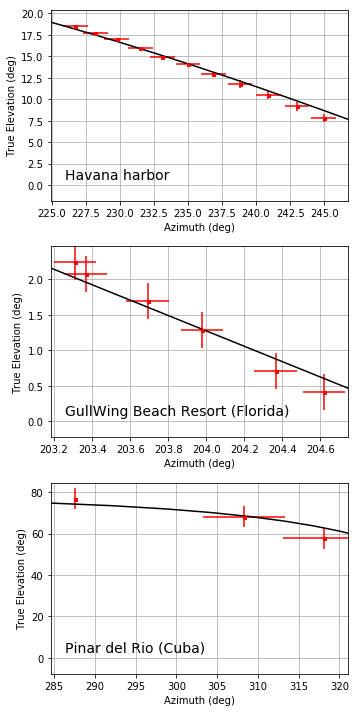

In [13]:
#Plot solution
fig,axs=plt.subplots(nvp,figsize=(5,10))
i=-1

for i,ax in enumerate(axs):
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("True Elevation (deg)")

#axs[0].set_title(f"Trajectory solution: Az = {solution.x[3]:.2f}, h = {solution.x[2]:.2f}",fontsize=10)

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1
    
    #Plot observed points
    axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'k-')
    axs[i].errorbar(vp["obstraj"]["Az"]+vp["Azref"],vp["obstraj"]["h"],
                    xerr=vp["obstraj"]["Azerr"],yerr=vp["obstraj"]["herr"],marker='s',ms=3,ls='',color='r')
    axs[i].text(0.05,0.1,vp["location"],ha='left',va='bottom',transform=axs[i].transAxes,fontsize=14)

    #Ranges
    Azmin=(vp["obstraj"]["Az"]+vp["Azref"]).min();Azmax=(vp["obstraj"]["Az"]+vp["Azref"]).max()
    hmin=0;hmax=vp["obstraj"]["h"].max()
    dAz=(Azmax-Azmin)/10.0
    dh=(hmax-hmin)/10.0
    
    axs[i].set_xlim((Azmin-dAz,Azmax+dAz))
    axs[i].set_ylim((hmin-dh,hmax+dh))
    axs[i].grid()
    
fig.savefig(FIGDIR+"trajectory-fit.png")
fig.tight_layout()

### Compute the trajectory and the foot print

In [14]:
#Find trajectory from first sight in Havana
vp=vantagePoints["havana"]
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()

#Traverse the theoretical trajectory
dAzmin_min=1e100
imin=0
for i in range(len(trajectory)):
    rpos=trajectory[i]
    d,Az,h=rec2loc(vp,rpos)
    dAzmin=np.abs(Az-(Azmin))
    dAzmax=np.abs(Az-(Azmax))
    if dAzmin<=dAzmin_min:
        imin=i
        dAzmin_min=dAzmin
trajectory_sel=trajectory[0:imin]

#Compute geographical positions
traj=trajectory_sel 
trajectory_geo=[]
for i,point in enumerate(traj):
    lon,lat,alt=spy.recgeo(point,RE,F)
    if alt>80:break
    trajectory_geo+=[[lon*RAD,lat*RAD,alt]]
trajectory_geo=np.array(trajectory_geo)

In [15]:
trajstr=""
footprint=""
polygon=f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},0\n"
for point in trajectory_geo:
    trajstr+=f"				{point[0]},{point[1]},{point[2]*1000}\n"
    footprint+=f"				{point[0]},{point[1]},0\n"
    polygon+=f"				{point[0]},{point[1]},{point[2]*1000}\n"
polygon+=f"				{trajectory_geo[-1,0]},{trajectory_geo[-1,1]},0\n"
polygon+=f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},0\n"

f=open(BDIR+"data/cuba-trajectory-Zuluaga_et_al_2019.kml","w")
f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>Cuba Meteor Trajectory, Zuluaga et al. (2019)</name>
	<Style id="trajectory">
		<IconStyle>
		</IconStyle>
		<BalloonStyle>
		</BalloonStyle>
		<LineStyle>
			<color>ff1bffd9</color>
			<width>2.5</width>
		</LineStyle>
	</Style>
	<Style id="footprint">
		<IconStyle>
		</IconStyle>
		<BalloonStyle>
		</BalloonStyle>
		<LineStyle>
			<color>FF3611fc</color>
			<width>2.5</width>
		</LineStyle>
	</Style>
	<Style id="polygon">
		<LineStyle>
			<color>7F3611fc</color>
			<width>0</width>
		</LineStyle>
		<PolyStyle>
            <color>7F3611fc</color>
            <fill>1</fill>
		</PolyStyle>
	</Style>
	<Placemark>
		<name>Trajectory</name>
		<styleUrl>trajectory</styleUrl>
		<LineString>
			<tessellate>1</tessellate>
			<altitudeMode>relativeToGround</altitudeMode>
			<coordinates>
                {trajstr}
            </coordinates>
		</LineString>
	</Placemark>
	<Placemark>
		<name>Footprint</name>
		<styleUrl>footprint</styleUrl>
		<LineString>
			<tessellate>1</tessellate>
            <altitudeMode>clampToGround</altitudeMode>
			<coordinates>
                {footprint}
            </coordinates>
		</LineString>
	</Placemark>
	<Placemark>
		<name>Polygon</name>
		<styleUrl>polygon</styleUrl>
		<Polygon>
			<altitudeMode>relativeToGround</altitudeMode>
			<outerBoundaryIs>
				<LinearRing>
					<coordinates>
                        {polygon}
                    </coordinates>
				</LinearRing>
			</outerBoundaryIs>
		</Polygon>
	</Placemark>
</Document>
</kml>
""")
f.close()

### Compute speed

In [16]:
vp=vantagePoints["havana"]

#Range of interpolation
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()
Azmax=(vp["obstraj"]["Az"].values+vp["Azref"]).max()
tmin=vp["obstraj"]["t"].min()
tmax=vp["obstraj"]["t"].max()

i_ini=0;i_end=10
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"])[i_ini]
Azmax=(vp["obstraj"]["Az"].values+vp["Azref"])[i_end]
tmin=vp["obstraj"]["t"][i_ini]
tmax=vp["obstraj"]["t"][i_end]

#Traverse the theoretical trajectory
dAzmin_min=1e100
dAzmax_min=1e100
imin=0;imax=0
for i in range(len(trajectory)):
    rpos=trajectory[i]
    d,Az,h=rec2loc(vp,rpos)
    dAzmin=np.abs(Az-(Azmin))
    dAzmax=np.abs(Az-(Azmax))
    if dAzmin<=dAzmin_min:
        imin=i
        dAzmin_min=dAzmin
    if dAzmax<=dAzmax_min:
        imax=i
        dAzmax_min=dAzmax
trajectory_sel=trajectory[imax:imin]

### Interpolate points in trajectory

In [17]:
#vp=vantagePoints["florida"]
vp=vantagePoints["havana"]

#Build fulltrajectory
fulltrajectory=np.concatenate((trajectory,vp["theotraj"]),axis=1)

#Interpolate positions
xfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,0])
yfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,1])
zfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,2])

#Calculate distance cover between observed points
spoints=np.zeros((len(vp["obstraj"]),5))
for i,point in enumerate(vp["obstraj"].values):
    Az=point[2]+vp["Azref"]
    t=point[4]
    intpoint=[float(xfunc(Az)),float(yfunc(Az)),float(zfunc(Az))]
    if i==0:
        distance=0
    else:
        distance=norm(intpoint-spoints[0,:3])
    spoints[i]=np.array(intpoint+[distance,t])
    
#Ranges
tmin=spoints[:,4].min();tmax=spoints[:,4].max()

#Perform linear regression of times and distances
regression=linregress(spoints[:,4],spoints[:,3])
d0=regression.intercept;vimp=regression.slope

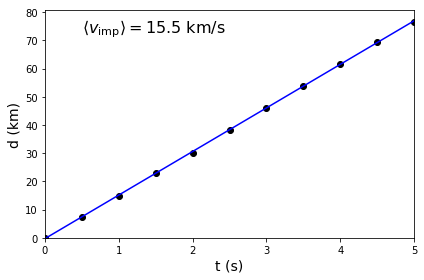

In [18]:
fig=plt.figure()
ax=fig.gca()

ax.plot(spoints[:,4],spoints[:,3],'ko')
ts=np.linspace(tmin,tmax,100)
ax.plot(ts,d0+vimp*ts,'b-')

ax.set_xlabel("t (s)",fontsize=14)
ax.set_ylabel("d (km)",fontsize=14)

ax.text(0.1,0.9,r"$\langle v_{\rm imp}\rangle=%.1f$ km/s"%vimp,transform=ax.transAxes,fontsize=16)

ymin,ymax=ax.get_ylim()
ax.set_xlim((0,tmax))
ax.set_ylim((0,ymax))

fig.tight_layout()
fig.savefig(FIGDIR+"impact-speed.png")

### LaTeX tables

In [19]:
for key,vp in vantagePoints.items():
    if key=="impact":continue
    print("\\hline\\multicolumn{4}{c}{%s}\\\\\\hline"%vp['location']) 
    for i,point in enumerate(vp["obstraj"].values):
        if key=="pinar":t="-"
        else:t=f"{point[4]:.2f}"
        if key=="florida":Az=r"$A_{\rm ref}$"+f"+{point[2]:.1f}"
        else:Az=f"{point[2]:.2f}"            
        #print(f"{i+1} & %.1f $\pm$ {point[3]:.1g} & {point[0]:.1f} $\pm$ {point[1]:.1g} & {t} \\\\"%(point[2]+vp["Azref"]))
        print(f"{i+1} & {Az} $\pm$ {point[3]:.1g} & {point[0]:.1f} $\pm$ {point[1]:.1g} & {t} \\\\"%(point[2]+vp["Azref"]))

\hline\multicolumn{4}{c}{Havana harbor}\\\hline
1 & 226.74 $\pm$ 0.9 & 18.6 $\pm$ 0.07 & 0.00 \\
2 & 228.22 $\pm$ 0.9 & 17.7 $\pm$ 0.07 & 0.50 \\
3 & 229.77 $\pm$ 0.9 & 17.0 $\pm$ 0.07 & 1.00 \\
4 & 231.51 $\pm$ 0.9 & 16.0 $\pm$ 0.07 & 1.50 \\
5 & 233.13 $\pm$ 0.9 & 15.0 $\pm$ 0.07 & 2.00 \\
6 & 235.00 $\pm$ 0.9 & 14.1 $\pm$ 0.07 & 2.50 \\
7 & 236.87 $\pm$ 0.9 & 13.0 $\pm$ 0.07 & 3.00 \\
8 & 238.82 $\pm$ 0.9 & 11.8 $\pm$ 0.5 & 3.50 \\
9 & 240.89 $\pm$ 0.9 & 10.5 $\pm$ 0.5 & 4.00 \\
10 & 243.00 $\pm$ 0.9 & 9.2 $\pm$ 0.5 & 4.50 \\
11 & 244.96 $\pm$ 0.9 & 7.8 $\pm$ 0.5 & 5.00 \\
\hline\multicolumn{4}{c}{GullWing Beach Resort (Florida)}\\\hline
1 & $A_{\rm ref}$+10.1 $\pm$ 0.1 & 2.2 $\pm$ 0.3 & 0.44 \\
2 & $A_{\rm ref}$+10.2 $\pm$ 0.1 & 2.1 $\pm$ 0.3 & 0.50 \\
3 & $A_{\rm ref}$+10.5 $\pm$ 0.1 & 1.7 $\pm$ 0.3 & 0.81 \\
4 & $A_{\rm ref}$+10.8 $\pm$ 0.1 & 1.3 $\pm$ 0.3 & 0.94 \\
5 & $A_{\rm ref}$+11.2 $\pm$ 0.1 & 0.7 $\pm$ 0.3 & 1.94 \\
6 & $A_{\rm ref}$+11.5 $\pm$ 0.1 & 0.4 $\pm$ 0.3 & 2.31 

### Trajectory per vantage point

In [20]:
vantagePoints["havana"]["kmlcolor"]="F04614"
vantagePoints["florida"]["kmlcolor"]="3CBE14"
vantagePoints["pinar"]["kmlcolor"]="5078F0"

for key,vp in vantagePoints.items():
    if key=="impact":continue
    print(f"Preparing all trajectory products for '{key}' vantage point...")
    kmlcolor=vp["kmlcolor"]
    location=vp["location"]
    vplon=vp["lon"]
    vplat=vp["lat"]
    vpalt=vp["alt"]*1000

    #Range of interpolation
    Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()
    Azmax=(vp["obstraj"]["Az"].values+vp["Azref"]).max()

    #Traverse the theoretical trajectory
    dAzmin_min=1e100
    dAzmax_min=1e100
    dgreat_min=0
    dgreat_max=0
    dgreats=[]
    imin=0;imax=0
    for i in range(len(trajectory)):
        rpos=trajectory[i]
        d,Az,h=rec2loc(vp,rpos)
        if i==0:
            Azini=Az
            hini=h
            dgreat=0
        else:
            dgreat=greatCircle(Az*DEG,h*DEG,Azini*DEG,hini*DEG)*RAD
        dgreats+=[dgreat]
        dAzmin=np.abs(Az-(Azmin))
        dAzmax=np.abs(Az-(Azmax))
        if dAzmin<=dAzmin_min:
            imin=i
            dAzmin_min=dAzmin
            dgreat_min=dgreat
        if dAzmax<=dAzmax_min:
            imax=i
            dAzmax_min=dAzmax
            dgreat_max=dgreat
    trajectory_sel=trajectory[imax:imin]
    
    #Store only the great circle distance for Pinar del Rio
    if key=="pinar":
        print(f"Initial point of Pinar del Rio: {imin}")
        imin_sel=imin
        dgreats_sel=dgreats
    
    #Geographical trajectory
    traj=trajectory_sel #This is the trajectory only for the Vantage point
    trajectory_geo=[]
    for i,point in enumerate(traj):
        lon,lat,alt=spy.recgeo(point,RE,F)
        if alt>80:break
        trajectory_geo+=[[lon*RAD,lat*RAD,alt]]
    trajectory_geo=np.array(trajectory_geo)
    
    #Build fulltrajectory
    vp["fulltraj"]=fulltrajectory=np.concatenate((trajectory,vp["theotraj"]),axis=1)

    #Interpolate positions
    xfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,0])
    yfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,1])
    zfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,2])

    #Calculate distance cover between observed points
    vp["spoints"]=spoints=np.zeros((len(vp["obstraj"]),8))
    for i,point in enumerate(vp["obstraj"].values):
        Az=point[2]+vp["Azref"]
        t=point[4]
        intpoint=[float(xfunc(Az)),float(yfunc(Az)),float(zfunc(Az))]
        lon,lat,alt=spy.recgeo(intpoint,RE,F)
        if i==0:
            distance=0
        else:
            distance=norm(intpoint-spoints[0,:3])
        spoints[i]=np.array(intpoint+[distance,t,lon*RAD,lat*RAD,alt])
        
    #Generate kml trajectory
    trajstr=""
    polygon=""
    polygon+=f"				{vplon},{vplat},{vpalt}\n"
    polygon+=f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},{trajectory_geo[0,2]*1000}\n"
    polygon+=f"				{trajectory_geo[-1,0]},{trajectory_geo[-1,1]},{trajectory_geo[-1,2]*1000}\n"
    polygon+=f"				{vplon},{vplat},{vpalt}\n"
    for point in trajectory_geo:
        trajstr+=f"				{point[0]},{point[1]},{point[2]*1000}\n"

    f=open(BDIR+f"data/cuba-{key}-Zuluaga_et_al_2019.kml","w")
    f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>{location} - Cuba Meteor Trajectory, Zuluaga et al. (2019)</name>
	<Style id="polygon">
		<LineStyle>
			<color>7F3611fc</color>
			<width>0</width>
		</LineStyle>
		<PolyStyle>
            <color>7f{kmlcolor}</color>
            <fill>1</fill>
		</PolyStyle>
	</Style>
	<Placemark>
		<name>Polygon</name>
		<styleUrl>polygon</styleUrl>
		<Polygon>
			<altitudeMode>relativeToGround</altitudeMode>
			<outerBoundaryIs>
				<LinearRing>
					<coordinates>
                        {polygon}
                    </coordinates>
				</LinearRing>
			</outerBoundaryIs>
		</Polygon>
	</Placemark>
</Document>
</kml>
""")
    f.close()

Preparing all trajectory products for 'havana' vantage point...
Preparing all trajectory products for 'florida' vantage point...
Preparing all trajectory products for 'pinar' vantage point...
Initial point of Pinar del Rio: 41


In [21]:
iexpl=35
dexpl=dgreats_sel[iexpl]-dgreats_sel[imin_sel]
geoexpl=spy.recgeo(trajectory[iexpl],RE,F)
print(f"Angle from top of the pole to explosion: {dexpl} deg")
print(f"Height of the explosion: {geoexpl[2]} km")

Angle from top of the pole to explosion: -15.528427356121611 deg
Height of the explosion: 27.440996224022168 km


In [34]:
#vp=vantagePoints["havana"]
vp=vantagePoints["pinar"]
#vp=vantagePoints["florida"]
pd.DataFrame(vp["spoints"],columns=["x","y","z","d","t","lon","lat","alt"])

,x,y,z,d,t,lon,lat,alt
0,642.806456,-5892.594294,2431.570769,0.000000,0.0,-83.774382,22.438954,31.859677
1,641.906310,-5888.497600,2434.580740,5.162663,0.0,-83.778741,22.478271,29.155682
2,641.233232,-5885.434326,2436.831425,9.023008,0.0,-83.782004,22.507691,27.135773


### Generate initial conditions for gravitational ray tracing

In [23]:
solution.x

array([-83.82644838,  22.90718073,  31.13384843, 174.09842479,
       193.1647218 ])

In [24]:
#Solution
lon=solution.x[0];dlonp=+0.05;dlonm=-0.05
lat=solution.x[1];dlatp=+0.05;dlatm=-0.05
Azrad=solution.x[3];dAzradp=+5.0;dAzradm=-5.0
hrad=solution.x[2];dhradp=+1.0;dhradm=-1.0
vimp=vimp;dvimpp=+0.5;dvimpm=-0.5

In [25]:
#Generate GRT files
N=20

#Velocities
f=open("data/velocities.dat.cuba_error","w")
vmax=vimp+dvimpp
vmin=vimp+dvimpm
for i in range(N):
    v=vmin+(vmax-vmin)*np.random.rand()
    f.write(f"{v}\t-1\n")
f.close()

#Directions
f=open("data/directions.dat.cuba_error","w")
Azradmax=Azrad+dAzradp
Azradmin=Azrad+dAzradm
hradmax=hrad+dhradp
hradmin=hrad+dhradm
for i in range(N):
    Az=Azradmin+(Azradmax-Azradmin)*np.random.rand()
    h=hradmin+(hradmax-hradmin)*np.random.rand()
    f.write(f"-1\t-1\t{Az}\t{h}\n")
f.close()

#Locations
f=open("data/locations.dat.cuba_error","w")
lonmax=lon+dlonp
lonmin=lon+dlonm
latmax=lat+dlatp
latmin=lat+dlatm
for i in range(N):
    lon=lonmin+(lonmax-lonmin)*np.random.rand()
    lat=latmin+(latmax-latmin)*np.random.rand()
    f.write(f"-1\t-1\t{lon}\t{lat}\n")
f.close()

In [26]:
#After running the GRT read all rays
#direrror="data/grt-Cuba_error-20190201181700-BE1E80/"
direrror="data/grt-Cuba_error-20190201181700-F57162/"
#direrror="data/grt-Cuba_error-20190201181700-D78859/"
#direrror="data/grt-Cuba_error-20190201181700-B71477/"

for i,physfile in enumerate(glob(f"{direrror}/*.phys")):
    data=np.loadtxt(physfile)
    if i==0:
        alldata=data
    else:
        alldata=np.concatenate((alldata,data),axis=0)

#Compute semimajor axis, period and Tisserand parameter
aes=alldata[:,9]/(1-alldata[:,10])
Ps=aes**1.5
Tps=1/aes+2*np.cos(alldata[:,11]*DEG)*np.sqrt(aes*(1-alldata[:,10]**2))
alldata=np.column_stack((alldata,aes,Ps,Tps))
#alldata=np.append(alldata,Ps)
#alldata=np.append(alldata,Tps)
        
#Perform analysis
percentiles=np.percentile(alldata,[15,50,85],axis=0)

In [27]:
alldata.shape

(997, 19)

In [28]:
props=[
    dict(
        name="a",
        symbol="a",
        units="AU",
        ind=16,
    ),
    dict(
        name="q",
        symbol="q",
        units="AU",
        ind=9,
    ),
    dict(
        name="e",
        symbol="e",
        units="AU",
        ind=10,
    ),
    dict(
        name="i",
        symbol="i",
        units="AU",
        ind=11,
    ),
    dict(
        name="W",
        symbol="\Omega",
        units="AU",
        ind=12,
    ),
    dict(
        name="o",
        symbol="\omega",
        units="AU",
        ind=13,
    ),
    dict(
        name="P",
        symbol="P",
        units="yr",
        ind=17,
    ),
    dict(
        name="Tp",
        symbol="T_p",
        units="adim.",
        ind=18,
    ),
]
pmeds=dict()
for prop in props:
    name=prop["name"]
    pmin,pmed,pmax=percentiles[:,prop["ind"]]
    pmeds[name]=pmed
    dpp=pmax-pmed;dpm=pmed-pmin
    print(f"{name} = {pmed:.2f}, d{name} = {(dpp+dpm)/2:.2g},")

a = 1.24, da = 0.061,
q = 0.81, dq = 0.021,
e = 0.34, de = 0.02,
i = 10.98, di = 0.31,
W = 132.33, dW = 0.065,
o = 288.44, do = 7.6,
P = 1.37, dP = 0.1,
Tp = 2.86, dTp = 0.011,


In [29]:
#Look for the closest trajectory
minsum=1e100
minelementos=None
for data in alldata:
    #print(data)
    suma=0
    elementos=dict()
    for prop in props:
        name=prop["name"]
        if name=="a":factor=1.0
        else:factor=1.0
        col=prop["ind"]
        val=data[col]
        suma+=factor*(val-pmeds[name])**2
        elementos[name]=val
        #print(f"{name} = {data[col]}, ref = {pmeds[name]}")
    suma=np.sqrt(suma)
    if suma<minsum:
        minsum=suma
        minelementos=elementos
        
print(minelementos)
print(pmeds)

{'a': 1.2234317984738947, 'q': 0.813247381792002, 'e': 0.33527362718016285, 'i': 11.10188016699527, 'W': 132.3178924911708, 'o': 288.44523380106244, 'P': 1.3532238586663896, 'Tp': 2.8625090462864877}
{'a': 1.2364761946789014, 'q': 0.8105888738489356, 'e': 0.3425416502267674, 'i': 10.977973477132167, 'W': 132.32748484729666, 'o': 288.44387020687884, 'P': 1.3749238302748583, 'Tp': 2.859912928150784}


In [30]:
for prop in props:
    name=prop["name"]
    pmin,pmed,pmax=percentiles[:,prop["ind"]]
    dpp=pmax-pmed;dpm=pmed-pmin
    pmed=minelementos[name]
    print(f"${prop['symbol']}$ ({prop['units']}) & ${pmed:.2f}^"+"{"+f"+{dpp:.2g}"+"}_{"+f"-{dpm:.2g}"+"}$\\\\")

$a$ (AU) & $1.22^{+0.036}_{-0.087}$\\
$q$ (AU) & $0.81^{+0.012}_{-0.03}$\\
$e$ (AU) & $0.34^{+0.017}_{-0.022}$\\
$i$ (AU) & $11.10^{+0.27}_{-0.36}$\\
$\Omega$ (AU) & $132.32^{+0.03}_{-0.099}$\\
$\omega$ (AU) & $288.45^{+4.3}_{-11}$\\
$P$ (yr) & $1.35^{+0.06}_{-0.14}$\\
$T_p$ (adim.) & $2.86^{+0.011}_{-0.01}$\\


### Mass and size of the rock

In [31]:
KTON=4.184e12 #J

#Estimated airburst energy
E=1.4*KTON #according to NASA Fireball database

#Luminous efficiency
eta=0.1

In [32]:
#Kinetic energy
K=E/eta

In [33]:
#Mass
M=2*K/(vimp*1e3)**2
print(f"Mass of the impactor: {M/1000:.0f} tons")

#Estimated density
rho=2600 #kg/m^2

#Diameter
D=2*(3*M/(4*np.pi*rho))**(1/3)
print(f"Diameter of the impactor: {D:.0f} m")

Mass of the impactor: 490 tons
Diameter of the impactor: 7 m
